## 3.2 - Model Generation

This secton covers the model training, testing, and tuning of both the Support Vector Machine and a Decision Tree.

### 3.3.1 - Support Vector Machine Training

For SVM training experimentation covered the following:
- a) use of multi-class for quality range of 0-1
- b) use of binary class for quality range of 0,1
- c) use of all features - standardized using StandardScaler
- d) use of select features with high correlation to quality outcome using StandardScaler

Experiments take advantage of the pipeline and grid search capabiliteis of SciKit that allows providing a range of parameters (hyperparameters) along with Preprocessing, the Model, and Cross Fold validation settings and SciKit learn will run through all the combinations and generate the "best" in terms of Accuracy.

#### 3.3.1.1 Loading and setting up test and training datasets.

Since we are going to use a cross fold with k = 10, we rely on Scikit's ability to split the train and test data sets during the fitting/training.  Scikit provides the spliting and stratification of the data. This is described in detail at [3.1. Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)


From the diagram below (also at the previous web page), this is a generalized view of cross validation. For each train iteration some subset of the overall data is for training, and testing. 

![](./images/grid_search_cross_validation.png)


##### 3.3.1.1.1 Stratified K Fold

For this experimentation, stratification is desired. This ensures that the classes are proportionally represented in each of the folds as the same proportion for the overall dataset. There is plenty of data for this to work well and given the data is binary classes (good, not good wine), this helps just a little bit. With greater number of classes this would have a greater impact.

The diagram below, also from the previous website, discusses the Scikit implementation of the StrafifiedKFold class. For this experiment we are not using groups.

![](./images/sphx_glr_plot_cv_indices_0071.png)



In [21]:
#this is for development only and not relevant
%load_ext autoreload
%autoreload


## lets load the data
from utils.helpers import *
df_red, df_white, df_all = pull_and_load_data(force = False)

# create a X_train that is just the features and the associated
# classes (labels) that have been convered to binary classes -- "not good wine", "good wine"
# as described before
X_train, y_train = get_features_and_labels(df_all, binary = True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
path exist and not forced
path exist and not forced


#### 3.3.1.2 - Model Hyperparameter Tuning

Here we leverage a grid search that will run through the model training. Within Scikit the GridSearchCV can provide a matrix search across all combinations of parameters along with k-fold cross validation of the underlying data. This helps with the manual effort of just run, change parameters, run, that experimentation provides.  This takes quite some time across a wider set of parameters. 

For Support Vector Machines the implementation in Scikit provides for two key parameters that affect the training and outcome. A detailed explanation and visualizations is here: [SVC Parameters When Using RBF Kernel - Classify Using a RBF Kernel](https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/).

These two key parameters are:
- C
    - essentially the tolerance for misclassified data and impact on the loss. When C is high, there is LESS tolerance and a penalty is paid; low C, there is greater tolerance and less penalty.
    
- gamma
    - Higher the gamma, better chance of overfitting. Gamma is the decision boundary, effectively the padding around the decision points.
    
    
As with fitting and training, there are iteratations for each run of the training data that the model sees before adjusting the next set of parameters during gradient descent.

For this exercise, some of these models take extremely long to converge and limiting the maximum iterations using the `n_iters` was used.


#### 3.3.1.2.1 - Pipeline

The pipeline allows establishing a data preprocessor, in this case the StandardScaler as mentioned in the prior section. Along with the paramter grid, and finally the cross validation module.

> Note: I had to explicitly include the `StratifiedKFold` instance as below as although GridSearchCV and the cross_val_score Scikit tools would use the same, they would NOT set the shuffle value to True. In this model I'd like to not rely on physical order, but random presentation of the data. I'm doing this as the final model I will not take from grid search, but from a direct `cross_val_score` run against the data with the **Best** parameters emitted from grid search.


**Now, ready to setup and fit...**



In [22]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model_pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('svm', SVC())
])

parameteres = {
    'svm__C':[1, 10, 100],
    'svm__gamma':[0.01, 0.1, 1.0, 100], #'scale'],
    #'svn__kernel' : ['rbf'], #this is the default
    'svm__max_iter':[1000000],
    'svm__random_state' : [42],
    'svm__verbose': [False]}

# 10 is the number of folks as requested in the project assignment.

skf = StratifiedKFold(n_splits = 10,
                      shuffle = True,
                      random_state = 42)

grid = GridSearchCV(
    model_pipeline,
    parameteres,
    cv = skf,
    return_train_score = True,
    verbose = 0
)

grid.fit(X_train, y_train)

print('done training')

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None,


#### 3.3.1.2.2 - Pipeline / Grid Result

Now lets take a look at the `best score`, `best parameters` as these will be what is used in the direct scoring run further down.


In [23]:

print("score = %3.4f" %(grid.best_score_))
print(grid.best_params_)

score = 0.8088
{'svm__C': 10, 'svm__gamma': 1.0, 'svm__max_iter': 1000000, 'svm__random_state': 42, 'svm__verbose': False}



We can see that the grid search best score is above, along with the best parameters that achieved that score.

#### 3.3.1.2.1 - Best Estimator

Interesting enough, we can retrieve the instance of the estimator (instance of the SVC class) and run the model for scoring against the dataset.

Lets emit a few values that come back from the grid search.


In [36]:

print('Best estimator score: {:.4f}'.format(grid.best_estimator_.score(X_train, y_train)))
print('Grid Score: {:.4f}'.format(grid.score(X_train, y_train)))
print('Grid Best Score: {:.4f}'.format(grid.best_score_))


Best estimator score: 0.9952
Grid Score: 0.9952
Grid Best Score: 0.8088



#### 3.3.1.2.2 - Explanation of differences

After this step, the Grid Best score is what we will work with. However, to explain why the differences in the scoring above you have to understand what the `best_estimator` is.

The `best_estimator+_` attached to the grid object is an instance of the solver, in this case SVC, that achieve the highest score **for a specific fold** - and not the entire cross validation iterations.  That same solver is also used when calling the grid's `score` function. It does not represent the best score and solver (with the specific parameters - C and gamma) that had the best score when run against all 10 folds.

The grid's `best_score_` attribute is that value.


#### 3.3.1.3 - Rerunning the Training

At this point we take a track that indicates we have optimized two key parameters, C and gamma, and again, apply a different function from Scikit that runs the same cross validation, but using one set of parameters.

This approach is still a great time saver as it eliminates the need to manually segment the data, ensure it is stratified, and collect the results.

First, the output of the grid search gave us:

```
score = 0.8088
{'svm__C': 10, 'svm__gamma': 1.0, 'svm__max_iter': 1000000, 'svm__random_state': 42, 'svm__verbose': False}
```

Now plug those into the SVC instance along with the same settings for the StratifedKFold processor.

The other key concern is ensuring we are also applying the same scaling to the data. Here again, the StandardScaler, as used in GridSerch above is used:



In [37]:
# to be sure, reload data from scratch:

## lets load the data
from utils.helpers import *
df_red, df_white, df_all = pull_and_load_data(force = False)

# create a X_train that is just the features and the associated
# classes (labels) that have been convered to binary classes -- "not good wine", "good wine"
# as described before
X_train, y_train = get_features_and_labels(df_all, binary = True)



path exist and not forced
path exist and not forced


In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

scaler = StandardScaler()  # Normalizer()
X = scaler.fit_transform(X_train)

skf = StratifiedKFold(n_splits = 10,
                      random_state = 42, 
                      shuffle = True)

svm = SVC(
    kernel = 'rbf',
    C = 10,
    gamma = 1.0,
    max_iter = 100000,
    random_state = 42,
    verbose = False)

scores = cross_val_score(
    svm,
    X, # used the scaled data...
    y_train,
    cv = skf,
    verbose = 0) #, scoring=scoring)


#The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores




Accuracy: 0.8088 (+/- 0.03)


array([0.79538462, 0.78461538, 0.82461538, 0.82307692, 0.80769231,
       0.82461538, 0.81846154, 0.8027735 , 0.81664099, 0.79044684])



#### 3.3.2 - ROC and AUC

There's plenty of observations that it is possible to generate the Receiver Operating Characteristics (ROC) curve and the Area Under the Curve (AUC).

With Skikit learn it takes use of the same `cross_validation` set of helper functions just supplying what `method` to be used.

In this case, the `SVC` class has a `decision_function` that can provide the probabilities needed for each of the data points. Normally, a call to `cross_val_predict` would call the `predict` on the classifer, which just provides the class prediction based upon the input features.

But here, we are using it to generate our ROC data.

In [68]:


from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(
    svm,
    X_train,
    y_train,
    cv = skf,
    method = 'decision_function',
    verbose = 0)

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

# we only have 0 or 1 as our classes (its binary)
for i in range(0,2):
    fpr[i], tpr[i], _ = roc_curve(y_train, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
        

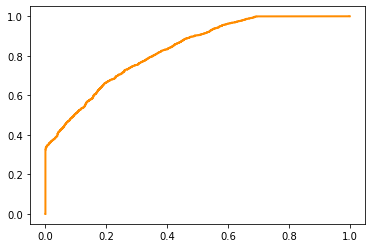

In [71]:
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])


### 3.3.3 Summary - TODO: move to bottom

In this section we ran some extensive training looking for optimal hyperparametes for the solver (algorithm) we used. While our grid search achieved a fairly high accuracy score, we also validated the result with a stand-alone cross validation scoring, while explaining some of the Scikit and Support Vector Machine implementation detials.

What we will seee with the other Classifier, a Decision Tree, there is quite a bit less to fiddle in terms of hyperparameters due to its deterministic and lack of optimization techniques like Gradient Descent.  The question is, which is better.


